# Compute Linear Response Function with RRTMG

## Import package

In [49]:
import h5py
import numpy as np
import climlab as cl

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

## Load data

In [50]:
# load mean state of moisture
with h5py.File( "/work/b11209013/2025_Research/MSI/Rad_Stuff/mean_state.h5", "r" ) as f:
    q_mean = np.array( f.get( "q" ) )[::-1] # kg/kg; 100 -> 1000
    t_mean = np.array( f.get( "t" ) )[::-1]

## Constructing RRTMG

In [51]:
# vertical coordinate in pressure
levels = np.linspace( 100.0, 1000.0, 37 )

nlevel = levels.size # number of vertical layers

# construct state object
state = cl.column_state( num_lev=nlevel, water_depth=1 )
state["Tatm"][:] = t_mean                                   # Use mean state of temperature in ERA5
state["Ts"][:] = state["Tatm"][-1]                       # Surface temperature

# calculate reference profile for radiative heating
rad_model  = cl.radiation.RRTMG(
    name="Radiation Model",
    state=state,
    specific_humidity=q_mean,
    albedo=0.3,
)

rad_model.compute_diagnostics() # calculate diagnostic field of this model

LW_ref = rad_model.diagnostics["TdotLW"] # longwave radiative heating
SW_ref = rad_model.diagnostics["TdotSW"] # shortwave radiative heating

del rad_model

## Perturb moisture and temperature and compute LRF

In [52]:
# pre-allocate library
LRF = {
    "q_lw" : np.zeros( (nlevel,nlevel) ),
    "q_sw" : np.zeros( (nlevel,nlevel) ),
    "t_lw" : np.zeros( (nlevel,nlevel) ),
    "t_sw" : np.zeros( (nlevel,nlevel) ),
}

# calculate linear response function for specific humidity
for l in range( nlevel ):
    q_perturb = deepcopy( q_mean )
    perturbation = q_perturb[l] * 0.01
    q_perturb[l] += perturbation # perturb specific humidity by 0.01 kg/kg

    rad_perturb = cl.radiation.RRTMG(
        name="Radiation Model",
        state=state,
        specific_humidity=q_perturb,
        albedo=0.3,
    )

    rad_perturb.compute_diagnostics()

    LRF[ "q_lw" ][l] = ( rad_perturb.diagnostics[ "TdotLW" ] - LW_ref ) / perturbation * 1e-3
    LRF[ "q_sw" ][l] = ( rad_perturb.diagnostics[ "TdotSW" ] - SW_ref ) / perturbation * 1e-3

    del q_perturb, rad_perturb

# calcuculate linear response function for temperature
for l in range( nlevel ):
    perturb_state = deepcopy( state )
    perturb_state[ "Tatm" ][l] += 1
    perturb_state[ "Ts" ][:] = perturb_state["Tatm"][-1]

    rad_perturb = cl.radiation.RRTMG(
        name="Radiation Model",
        state=perturb_state,
        specific_humidity=q_mean,
        albedo=0.3,
    )

    rad_perturb.compute_diagnostics()

    LRF[ "t_lw" ][l] = ( rad_perturb.diagnostics[ "TdotLW" ] - LW_ref ) / 1
    LRF[ "t_sw" ][l] = ( rad_perturb.diagnostics[ "TdotSW" ] - SW_ref ) / 1

    del perturb_state, rad_perturb

## Plot for check

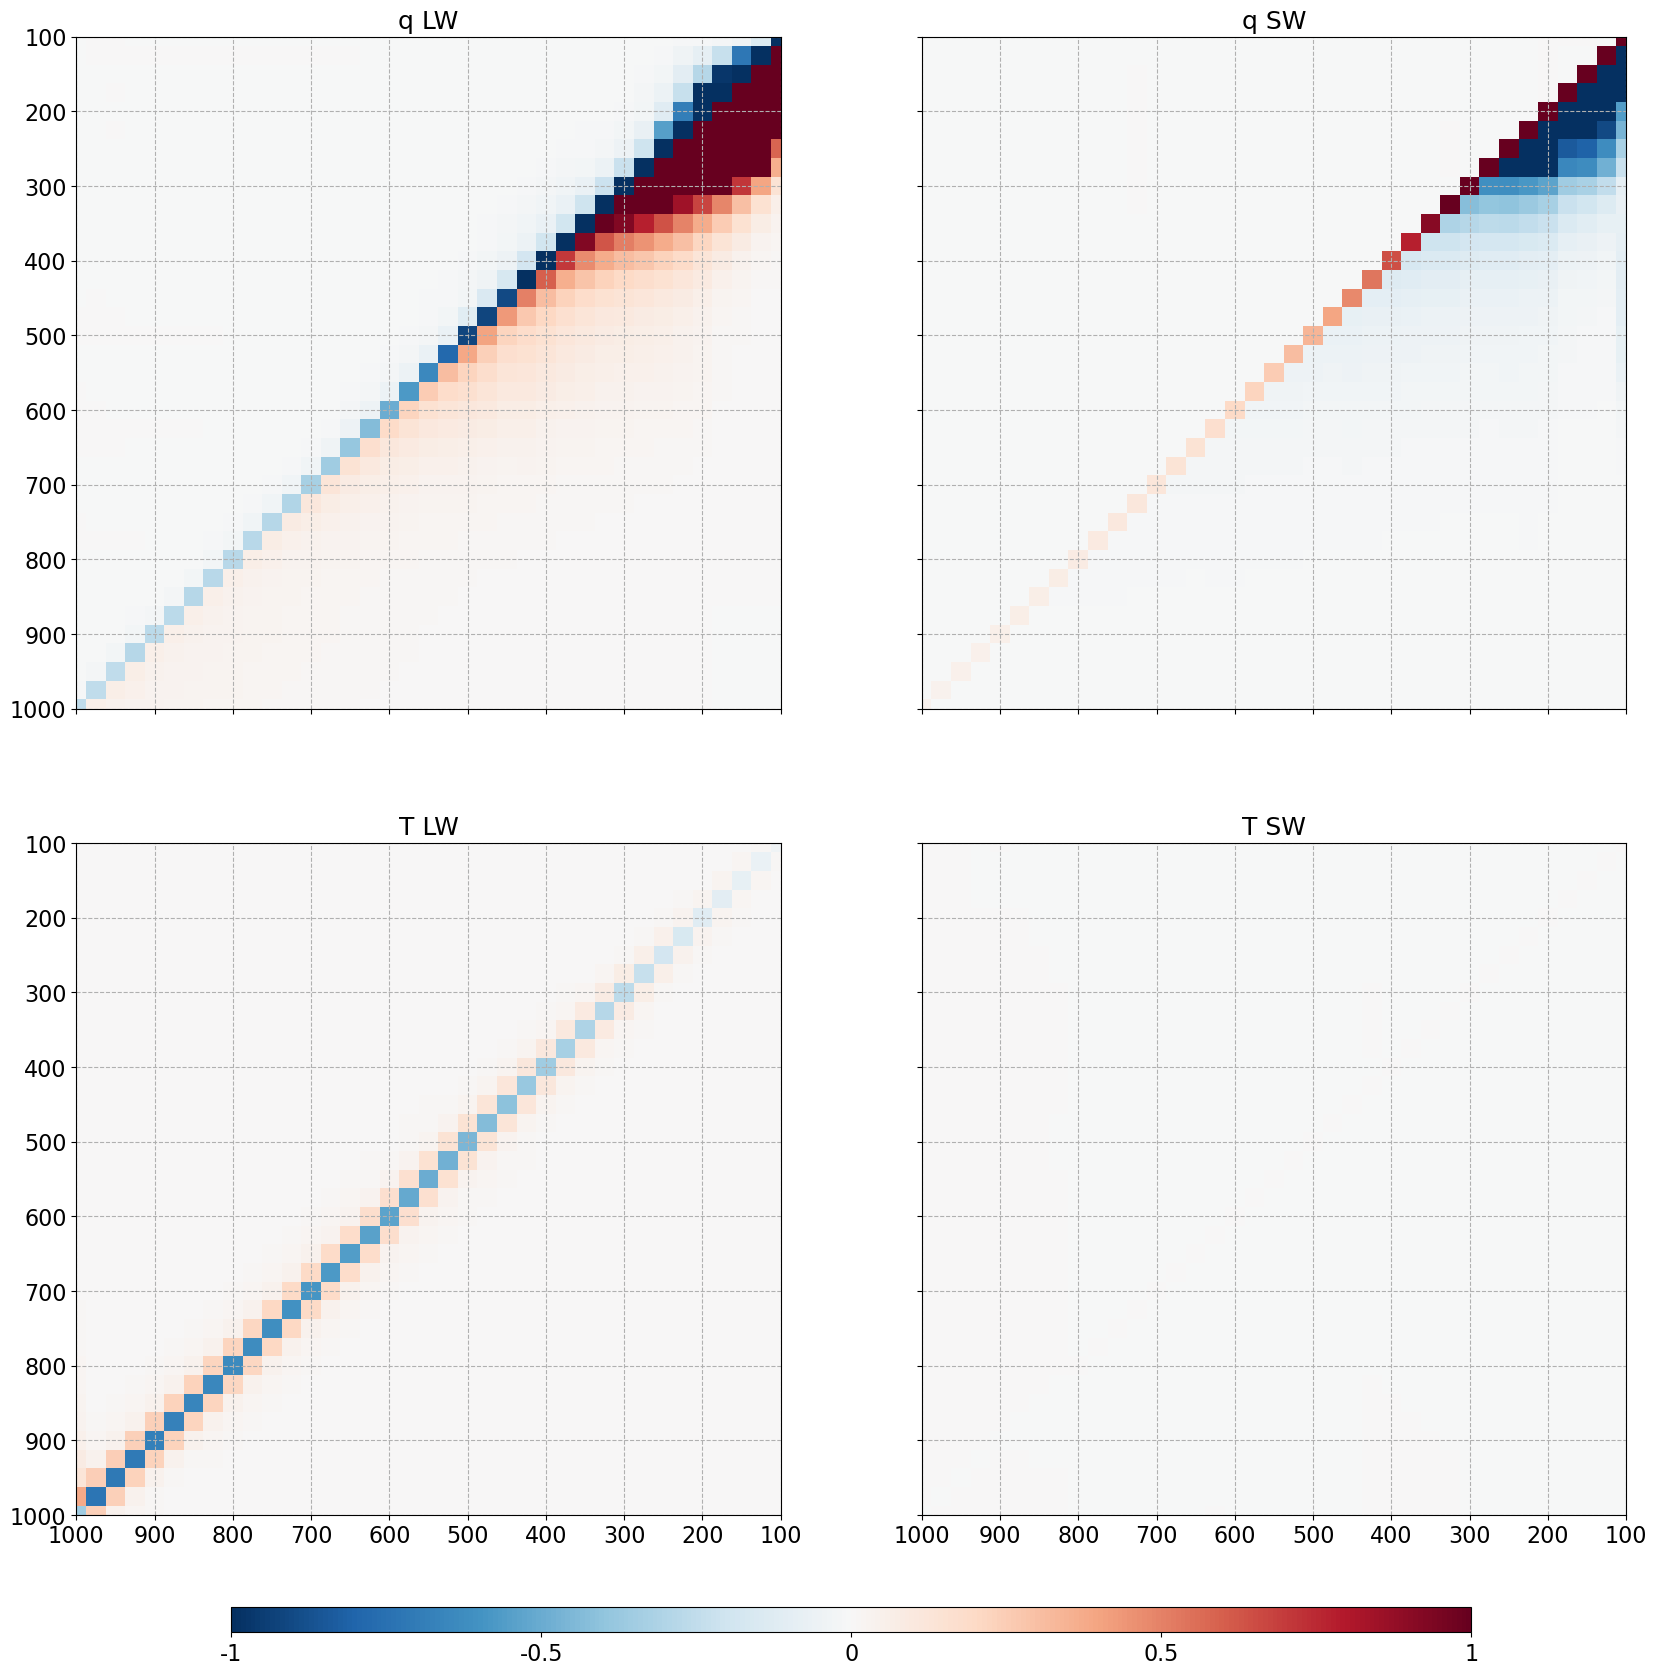

In [53]:
fig, ax = plt.subplots( 
    2, 2,
    sharex=True, sharey=True,
    figsize=(20,24) 
    )

pc = ax[0, 0].pcolormesh(
    levels, levels, LRF["q_lw"].T,
    cmap="RdBu_r", vmin=-1, vmax=1
)
ax[0, 0].set_xlim( 1000, 100 )
ax[0, 0].set_ylim( 1000, 100 )
ax[0, 0].set_yticks(np.linspace(1000, 100, 10))
ax[0, 0].set_yticklabels(
    ["1000","900","800","700","600","500","400","300","200","100"],
    fontsize=16
    )
ax[0, 0].set_title( "q LW", fontsize=18 )
ax[0, 0].grid(linestyle="--")

pc = ax[0, 1].pcolormesh(
    levels, levels, LRF["q_sw"].T,
    cmap="RdBu_r", vmin=-1, vmax=1
)
ax[0, 1].set_xlim( 1000, 100 )
ax[0, 1].set_ylim( 1000, 100 )
ax[0, 1].set_title( "q SW", fontsize=18 )
ax[0, 1].grid(linestyle="--")

pc = ax[1, 0].pcolormesh(
    levels, levels, LRF["t_lw"].T,
    cmap="RdBu_r", vmin=-1, vmax=1
)
ax[1, 0].set_xlim( 1000, 100 )
ax[1, 0].set_ylim( 1000, 100 )
ax[1, 0].set_xticks(np.linspace(1000, 100, 10))
ax[1, 0].set_xticklabels(
    ["1000","900","800","700","600","500","400","300","200","100"],
    fontsize=16
)
ax[1, 0].set_yticks(np.linspace(1000, 100, 10))
ax[1, 0].set_yticklabels(
    ["1000","900","800","700","600","500","400","300","200","100"],
    fontsize=16
)
ax[1, 0].set_title( "T LW", fontsize=18 )
ax[1, 0].grid(linestyle="--")

pc = ax[1, 1].pcolormesh(
    levels, levels, LRF["t_sw"].T,
    cmap="RdBu_r", vmin=-1, vmax=1
)
ax[1, 1].set_xticks(np.linspace(1000, 100, 10))
ax[1, 1].set_xticklabels(
    ["1000","900","800","700","600","500","400","300","200","100"],
    fontsize=16
)
ax[1, 1].set_xlim( 1000, 100 )
ax[1, 1].set_ylim( 1000, 100 )
ax[1, 1].set_title( "T SW", fontsize=18 )
ax[1, 1].grid(linestyle="--")

cbar = fig.colorbar( pc, ax=ax, orientation="horizontal", shrink=0.8, aspect=50, pad=0.05 )
cbar.set_ticks( [-1, -0.5, 0, 0.5, 1] )
cbar.set_ticklabels( ["-1", "-0.5", "0", "0.5", "1"], fontsize=16 )

plt.savefig( "/home/b11209013/2025_Research/MSI/Fig/Rad/qt_LRF.png", dpi=600, bbox_inches="tight" )
plt.show()

## Save Files

In [54]:
with h5py.File( "/work/b11209013/2025_Research/MSI/Rad_Stuff/LRF.h5", "w" ) as f:
    f.create_dataset( "q_lw", data=LRF["q_lw"].T )
    f.create_dataset( "q_sw", data=LRF["q_sw"].T )
    f.create_dataset( "t_lw", data=LRF["t_lw"].T )
    f.create_dataset( "t_sw", data=LRF["t_sw"].T )